In [ ]:
from typing import List, Sequence, Tuple
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

def brier_scores(df: pd.DataFrame) -> List[pd.Series]:
    """
    Compute and plot daily Brier scores for each CV fold and their ensemble mean.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
          - 'date' (datetime or date)
          - 'target' (0 or 1)
          - one or more 'pred_foldX' columns with predictions in [0,1]

    Returns
    -------
    List[pd.Series]
        A list of daily‐averaged Brier score time series:
        one for each fold (in order of pred_fold columns),
        and a final entry for the ensemble mean prediction.
    """
    df = df.copy()
    plt.figure(figsize=(14, 6))

    brier_series: List[pd.Series] = []
    pred_cols = [c for c in df.columns if c.startswith("pred_fold")]

    # Compute per‐fold Brier scores
    for i, col in enumerate(pred_cols, start=1):
        score_col = f"fold{i}_brier"
        df[score_col] = (df["target"] - df[col]) ** 2
        daily_avg = df.groupby("date")[score_col].mean()
        plt.plot(daily_avg, label=f"Fold {i} Brier")
        brier_series.append(daily_avg)

    # Compute ensemble mean prediction if not present
    if "mean_fold_pred" not in df.columns:
        df["mean_fold_pred"] = df[pred_cols].mean(axis=1)

    # Compute Brier score for ensemble mean
    df["mean_brier"] = (df["target"] - df["mean_fold_pred"]) ** 2
    daily_mean = df.groupby("date")["mean_brier"].mean()
    plt.plot(daily_mean, label="Mean Brier")
    brier_series.append(daily_mean)

    # Baseline line (random forecast Brier = 0.25 for binary 0/1)
#    plt.axhline(0.25, color="black", linestyle="--", label="Baseline 0.25")

    # Final plot touches
#    plt.title("Daily Brier Scores by Fold")
#    plt.xlabel("Date")
#    plt.ylabel("Brier Score")
#    plt.grid(True)
#    plt.legend()
#    plt.tight_layout()
#    plt.show()

    return brier_series

In [ ]:
from typing import Union
import numpy as np
import pandas as pd
import statsmodels.api as sm

def compute_perf_stats(
    daily_ret: pd.Series,
    trading_days: int = 252,
    mar: float = 0.0,
    scaled: bool = False,
    hac_lags: int = 5
) -> pd.Series:
    """
    Performance stats for a daily-return series.

    Parameters
    ----------
    daily_ret     : pd.Series of daily returns (raw pct or σ units).
    trading_days  : # trading days per year (252 for daily data).
    mar           : minimum acceptable return (annualised).
    scaled        : False → treat returns as fractional (\delta P / P);
                    True  → treat as additive σ-scaled P&L.
    hac_lags      : # lags for Newey-West (HAC) t-stat.

    Returns
    -------
    pd.Series with
      ann_return, ann_vol, Sharpe, Sortino, Max_Drawdown, t_stat
    """
    daily_ret = daily_ret.dropna().astype(float)
    N = len(daily_ret)
    if N == 0:
        raise ValueError("daily_ret is empty after NaNs removed.")

    # ---------- wealth curve & annualised return ----------
    if scaled:
        wealth = daily_ret.cumsum()
        ann_ret = daily_ret.mean() * trading_days
    else:
        wealth = (1 + daily_ret).cumprod()
        ann_ret = wealth.iloc[-1]**(trading_days / N) - 1

    # ---------- annualised vol ----------
    ann_vol = daily_ret.std(ddof=1) * np.sqrt(trading_days)

    # ---------- Sharpe & Sortino ----------
    sharpe = ann_ret / ann_vol if ann_vol else np.nan

    mar_daily = (1 + mar)**(1 / trading_days) - 1 if not scaled else mar / trading_days
    downside = daily_ret[daily_ret < mar_daily]
    dvol = downside.std(ddof=0) * np.sqrt(trading_days) if len(downside) else np.nan
    sortino = (ann_ret - mar) / dvol if dvol else np.nan

    # ---------- max drawdown ----------
    if scaled:
        peak = wealth.cummax()
        dd   = wealth - peak
    else:
        peak = wealth.cummax()
        dd   = (wealth - peak) / peak
    max_dd = dd.min()

    # ---------- HAC Newey-West t-stat ----------
    X = np.ones(N)
    model = sm.OLS(daily_ret.values, X).fit(
        cov_type="HAC", cov_kwds={"maxlags": hac_lags}
    )
    t_stat = float(model.tvalues[0])

    # ---------- total return over the whole period ----------
    if scaled:
        total_ret = wealth.iloc[-1]          # additive σ-units
    else:
        total_ret = wealth.iloc[-1] - 1.0    # geometric (fractional)

    return pd.Series(
        {
            "ann_return":   ann_ret,
            "ann_vol":      ann_vol,
            "Sharpe":       sharpe,
            "Sortino":      sortino,
            "Max_Drawdown": max_dd,
            "t_stat":       t_stat,
            "total_return": total_ret,
        }
    )

In [ ]:
from typing import Sequence, Tuple
import pandas as pd
import matplotlib.pyplot as plt

def plot_mean_brier_train_oos(
    train_brier: Sequence[pd.Series],
    oos_brier: Sequence[pd.Series],
    baseline: float = 0.25,
    figsize: Tuple[int, int] = (14, 6)
) -> None:
    """
    Plot the mean daily Brier score for training vs. out-of-sample.

    Parameters
    ----------
    train_brier : Sequence[pd.Series]
        A list of daily‐averaged Brier score series for each fold on the training set.
        The **last** element is taken as the overall “mean Brier” for train.
    oos_brier : Sequence[pd.Series]
        A list of daily‐averaged Brier score series for each fold on the held-out set.
        The **last** element is taken as the overall “mean Brier” for OOS.
    baseline : float, default 0.25
        The horizontal baseline Brier score to plot (e.g. random-forecast level).
    figsize : Tuple[int, int], default (14, 6)
        Figure size in inches for the matplotlib plot.

    Returns
    -------
    None
    """
    train_mean = train_brier[-1]
    oos_mean   = oos_brier[-1]

    plt.figure(figsize=figsize)
    plt.plot(train_mean.index, train_mean.values,
             label="Train – mean Brier", color="blue")
    plt.plot(oos_mean.index,   oos_mean.values,
             label="OOS – mean Brier",   color="green")
    plt.axhline(baseline, color="black", linestyle="--",
                label=f"Baseline {baseline}")

    plt.title("Mean Brier Score: Train vs OOS")
    plt.xlabel("Date")
    plt.ylabel("Brier Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
from typing import Callable, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from IPython.display import display

def full_strategy_report(
    test_data: pd.DataFrame,
    compute_perf_stats: Callable[[pd.Series, bool], pd.Series]
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
      1) Simple‐return P&L plot + stats
      2) σ‐scaled P&L plot + stats
      3) σ‐scaled leg plot + leg stats
      4) Round‐trip + precision table
    """
    df = test_data.copy()

    # ── 1) SIMPLE‐RETURN STRATEGY ────────────────────────────────────────
    df['strat_ret_simple'] = df['return_pct'] * df['pred']
    df['bh_ret_simple']    = df['return_pct']
    d_strat_simple = df.groupby('date')['strat_ret_simple'].mean()
    d_bh_simple    = df.groupby('date')['bh_ret_simple'].mean()

    stats_simple = pd.DataFrame({
        'Strategy':   compute_perf_stats(d_strat_simple, scaled=False),
        'Buy & Hold': compute_perf_stats(d_bh_simple,    scaled=False)
    }).T

    # 1a) plot simple‐return
    plt.figure(figsize=(10,4))
    (1 + d_bh_simple).cumprod().plot(label='Buy & Hold', lw=2, alpha=0.7)
    (1 + d_strat_simple).cumprod().plot(label='Strategy',    lw=2)
    plt.title("Raw‐Return P&L (start = 1.0)")
    plt.xlabel("Date"); plt.ylabel("Wealth")
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # 1b) display stats
    display(stats_simple)

    # ── 2) σ-SCALED STRATEGY ─────────────────────────────────────────────
    df['strat_ret_sigma'] = df['return_scaled'] * df['pred']
    df['bh_ret_sigma']    = df['return_scaled']
    d_strat_sigma = df.groupby('date')['strat_ret_sigma'].mean()
    d_bh_sigma    = df.groupby('date')['bh_ret_sigma'].mean()

    stats_sigma = pd.DataFrame({
        'Strategy':   compute_perf_stats(d_strat_sigma, scaled=True),
        'Buy & Hold': compute_perf_stats(d_bh_sigma,    scaled=True)
    }).T

    # 2a) plot σ-scaled
    plt.figure(figsize=(10,4))
    (d_bh_sigma.cumsum()).plot(label='Buy & Hold', lw=2, alpha=0.7)
    (d_strat_sigma.cumsum()).plot(label='Strategy',    lw=2)
    plt.title("σ-Scaled P&L (start = 1.0)")
    plt.xlabel("Date"); plt.ylabel("Index (σ-units)")
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # 2b) display stats
    display(stats_sigma)

    # ── 3) σ-SCALED LEGS ─────────────────────────────────────────────────
    all_dates = d_strat_simple.index
    simple_df = df.drop(columns=[c for c in df if c.startswith('emb_')])

    d_long_s = (simple_df[simple_df['pred']==1]
                .groupby('date')['return_scaled'].mean()
                .reindex(all_dates, fill_value=0))
    d_short_s = (simple_df[simple_df['pred']==-1]
                 .groupby('date')['return_scaled'].mean().mul(-1)
                 .reindex(all_dates, fill_value=0))

    # 3a) plot legs
    plt.figure(figsize=(10,4))
    (d_long_s.cumsum()).plot(label='Long Leg σ',  lw=2, color='green')
    (d_short_s.cumsum()).plot(label='Short Leg σ', lw=2, color='red')
    plt.title("Legs – σ-Scaled P&L")
    plt.xlabel("Date"); plt.ylabel("Index (σ-units)")
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # 3b) leg stats
    stats_legs_sigma = pd.DataFrame({
        'Long Leg σ':  compute_perf_stats(d_long_s,  scaled=True),
        'Short Leg σ': compute_perf_stats(d_short_s, scaled=True),
    }).T
    display(stats_legs_sigma)

    # ── 4) ROUND-TRIP + PRECISION TABLE ────────────────────────────────────
    longs_true   = simple_df[(simple_df['target']==1)  & (simple_df['pred']==1)]
    longs_false  = simple_df[(simple_df['target']==0)  & (simple_df['pred']==1)]
    shorts_true  = simple_df[(simple_df['target']==0)  & (simple_df['pred']==-1)]
    shorts_false = simple_df[(simple_df['target']==1)  & (simple_df['pred']==-1)]
    longs_all    = simple_df[simple_df['target']==1]
    shorts_all   = simple_df[simple_df['target']==0]

    rt_data = {
        "True Longs":   (longs_true['strat_ret_simple'].mean(),  len(longs_true)),
        "False Shorts": (shorts_false['strat_ret_simple'].mean(), len(shorts_false)),
        "True Shorts":  (shorts_true['strat_ret_simple'].mean(),  len(shorts_true)),
        "False Longs":  (longs_false['strat_ret_simple'].mean(), len(longs_false)),
        "Actual Longs": (longs_all['return_pct'].mean(),          len(longs_all)),
        "Actual Shorts":(shorts_all['return_pct'].mean(),        len(shorts_all)),
    }
    rt_df = pd.DataFrame.from_dict(
        {k: {'Avg Return':v[0], 'Count':v[1]} for k,v in rt_data.items()},
        orient='index'
    )

    y_true  = simple_df['target'].astype(int)
    y_pred  = (simple_df['pred']==1).astype(int)
    wgt     = simple_df['sample_weight']

    prec_long   = precision_score(y_true, y_pred, pos_label=1)
    prec_short  = precision_score(y_true, y_pred, pos_label=0)
    prec_long_w = precision_score(y_true, y_pred, pos_label=1, sample_weight=wgt)
    prec_short_w= precision_score(y_true, y_pred, pos_label=0, sample_weight=wgt)

    cnt_long  = int((y_pred==1).sum())
    cnt_short = int((y_pred==0).sum())

    prec_data = {
        "Predicted Longs": {'Avg Return':np.nan, 'Count':cnt_long,
                            'Precision':prec_long,  'Weighted Precision':prec_long_w},
        "Predicted Shorts":{'Avg Return':np.nan, 'Count':cnt_short,
                            'Precision':prec_short, 'Weighted Precision':prec_short_w},
    }
    prec_df = pd.DataFrame.from_dict(prec_data, orient='index')

    final_table = pd.concat([rt_df, prec_df], axis=0)
    display(final_table)

    return stats_simple, stats_sigma, stats_legs_sigma, final_table

In [ ]:
from typing import Callable, Tuple, List, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def build_weights(
    df: pd.DataFrame,
    p_col: str = "mean_pred",
    pred_col: str = "pred",
    mode: Literal["equal", "day", "mx"] = "day"
) -> pd.Series:

    if mode == "equal":
        return df[pred_col].astype(float)

    eps = 1e-6
    p   = df[p_col].clip(eps, 1 - eps)
    thr = p.mean()
    z   = np.log(p / (1 - p))
    z_thr = np.log(thr / (1 - thr))
    strength = (z - z_thr).abs()
    signed   = strength * df[pred_col]

    if mode == "mx":
        lo, hi = strength.min(), strength.max()
        span   = max(hi - lo, eps)
        scaled = (strength - lo) / span
        return scaled * df[pred_col]

    if mode == "day":
        # ▼ use max(...) instead of .clip(lower=…)
        return signed.groupby(df.index.get_level_values("date")) \
                     .transform(lambda x: x / max(x.abs().sum(), eps))

    raise ValueError("weight_mode must be 'equal', 'day', or 'mx'")


def full_strategy_report(
    pre_open_test: pd.DataFrame,
    compute_perf_stats: Callable[[pd.Series, bool], pd.Series],
    weight_mode: Literal["equal", "day", "mx"] = "day"
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    P&L & metrics for simple-return and σ-scaled versions, plus legs & round-trip.

    Parameters
    ----------
    pre_open_test      : DataFrame with 'return_pct', 'return_scaled',
                         'mean_pred', 'pred', 'target', 'sample_weight'.
    compute_perf_stats : user-supplied stats function.
    weight_mode        : "equal", "day", or "mx" (see build_weights).

    Returns
    -------
    stats_simple, stats_sigma, stats_legs_sigma, round_trip_table
    """
    df = pre_open_test.copy()

    # -------------------------------------------------------- simple-return
    df["weight"]          = build_weights(df, mode=weight_mode)
    df["strat_ret_simple"] = df["return_pct"] * df["weight"]
    df["bh_ret_simple"]    = df["return_pct"]

    d_strat_simple = df.groupby("date")["strat_ret_simple"].sum()
    d_bh_simple    = df.groupby("date")["bh_ret_simple"].mean()

    stats_simple = pd.DataFrame({
        "Strategy":   compute_perf_stats(d_strat_simple, scaled=False),
        "Buy & Hold": compute_perf_stats(d_bh_simple,    scaled=False)
    }).T

    plt.figure(figsize=(10,4))
    (1+d_bh_simple).cumprod().plot(label="Buy & Hold", lw=2, alpha=0.7)
    (1+d_strat_simple).cumprod().plot(label="Strategy", lw=2)
    plt.title(f"Raw-Return P&L  ({weight_mode} weights)"); plt.grid(); plt.legend(); plt.show()
    display(stats_simple)

    # -------------------------------------------------------- σ-scaled
    df["strat_ret_sigma"] = df["return_scaled"] * df["weight"]
    df["bh_ret_sigma"]    = df["return_scaled"]

    d_strat_sigma = df.groupby("date")["strat_ret_sigma"].sum()
    d_bh_sigma    = df.groupby("date")["bh_ret_sigma"].mean()

    stats_sigma = pd.DataFrame({
        "Strategy":   compute_perf_stats(d_strat_sigma, scaled=True),
        "Buy & Hold": compute_perf_stats(d_bh_sigma,    scaled=True)
    }).T

    plt.figure(figsize=(10,4))
    d_bh_sigma.cumsum().plot(label="Buy & Hold", lw=2, alpha=0.7)
    d_strat_sigma.cumsum().plot(label="Strategy", lw=2)
    plt.title(f"σ-Scaled P&L  ({weight_mode} weights)"); plt.grid(); plt.legend(); plt.show()
    display(stats_sigma)

    # -------------------------------------------------------- legs (σ)
    all_dates = d_strat_sigma.index
    long_leg  = (df[df["weight"] > 0]
                 .groupby("date")["strat_ret_sigma"].sum()
                 .reindex(all_dates, fill_value=0))
    short_leg = (df[df["weight"] < 0]
                 .groupby("date")["strat_ret_sigma"].sum()
                 .reindex(all_dates, fill_value=0))

    stats_legs_sigma = pd.DataFrame({
        "Long Leg":  compute_perf_stats(long_leg , scaled=True),
        "Short Leg": compute_perf_stats(short_leg, scaled=True)
    }).T

    plt.figure(figsize=(10,4))
    long_leg.cumsum().plot(label="Long Leg", lw=2, color="green")
    short_leg.cumsum().plot(label="Short Leg", lw=2, color="red")
    plt.title(f"σ-Scaled Legs  ({weight_mode})"); plt.grid(); plt.legend(); plt.show()
    display(stats_legs_sigma)

    # ── 4) ROUND-TRIP + PRECISION TABLE ───────────────────────────────────
    simple_df = df.copy()

    longs_true   = simple_df[(simple_df["target"] == 1) & (simple_df["pred"] ==  1)]
    longs_false  = simple_df[(simple_df["target"] == 0) & (simple_df["pred"] ==  1)]
    shorts_true  = simple_df[(simple_df["target"] == 0) & (simple_df["pred"] == -1)]
    shorts_false = simple_df[(simple_df["target"] == 1) & (simple_df["pred"] == -1)]
    longs_all    = simple_df[simple_df["target"] == 1]
    shorts_all   = simple_df[simple_df["target"] == 0]

    rt_data = {
        "True Longs":   (longs_true ["strat_ret_simple"].mean(), len(longs_true )),
        "False Shorts": (shorts_false["strat_ret_simple"].mean(), len(shorts_false)),
        "True Shorts":  (shorts_true ["strat_ret_simple"].mean(), len(shorts_true )),
        "False Longs":  (longs_false["strat_ret_simple"].mean(), len(longs_false)),
        "Actual Longs": (longs_all  ['return_pct']        .mean(), len(longs_all )),
        "Actual Shorts":(shorts_all ['return_pct']        .mean(), len(shorts_all)),
    }
    rt_df = pd.DataFrame.from_dict(
        {k: {"Avg Return": v[0], "Count": v[1]} for k, v in rt_data.items()},
        orient="index"
    )

    y_true  = (simple_df["target"] == 1).astype(int)
    y_pred  = (simple_df["pred"]   == 1).astype(int)
    weights = simple_df["sample_weight"]

    prec_long    = precision_score(y_true, y_pred, pos_label=1)
    prec_short   = precision_score(y_true, y_pred, pos_label=0)
    prec_long_w  = precision_score(y_true, y_pred, pos_label=1, sample_weight=weights)
    prec_short_w = precision_score(y_true, y_pred, pos_label=0, sample_weight=weights)

    cnt_long  = int((y_pred == 1).sum())
    cnt_short = int((y_pred == 0).sum())

    prec_df = pd.DataFrame.from_dict(
        {
            "Predicted Longs":  {
                "Avg Return": np.nan,
                "Count": cnt_long,
                "Precision": prec_long,
                "Weighted Precision": prec_long_w,
            },
            "Predicted Shorts": {
                "Avg Return": np.nan,
                "Count": cnt_short,
                "Precision": prec_short,
                "Weighted Precision": prec_short_w,
            },
        },
        orient="index",
    )

    final_table = pd.concat([rt_df, prec_df], axis=0)
    display(final_table)

    return stats_simple, stats_sigma, stats_legs_sigma, final_table


In [ ]:
from typing import Optional, Sequence, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    brier_score_loss,
    matthews_corrcoef,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report
)
from sklearn.calibration import calibration_curve

def plot_binary_metrics(
    p_test: Sequence[float],
    y_test: Sequence[int],
    threshold: float,
    title: str = "ICM head",
    p_val: Optional[Sequence[float]] = None,
    y_val: Optional[Sequence[int]] = None
) -> Dict[str, float]:
    """
    Plot and report a suite of binary‐classification metrics at a fixed threshold.

    Parameters
    ----------
    p_test : Sequence[float]
        Predicted probabilities on the test set (values in [0,1]).
    y_test : Sequence[int]
        True binary labels for the test set (0 or 1).
    threshold : float
        Probability cutoff for classifying positive (>= threshold → 1).
    title : str, default "ICM head"
        Title prefix for all plots and printouts.
    p_val : Optional[Sequence[float]], default None
        Predicted probabilities on a validation set; if provided along with
        `y_val`, will print validation F1 and MCC at the same threshold.
    y_val : Optional[Sequence[int]], default None
        True binary labels for the validation set.

    Returns
    -------
    Dict[str, float]
        A dictionary containing:
          - 'brier':  Brier score on the test set
          - 'ece':    Expected Calibration Error on the test set
          - 'f1':     F1 score on the test set
          - 'mcc':    Matthews correlation coefficient on the test set
          - 'thr':    The threshold used
    """
    # Optional validation‐set metrics
    if p_val is not None and y_val is not None:
        y_pred_val = (np.array(p_val) >= threshold).astype(int)
        f1_val  = f1_score(y_val, y_pred_val)
        mcc_val = matthews_corrcoef(y_val, y_pred_val)
        print(f"{title}: threshold={threshold:.2f}  (VAL F1={f1_val:.3f}  MCC={mcc_val:.3f})")

    # Test‐set predictions
    p_test_arr = np.array(p_test)
    y_test_arr = np.array(y_test)
    y_pred_test = (p_test_arr >= threshold).astype(int)

    # Brier score
    brier = brier_score_loss(y_test_arr, p_test_arr)

    # Expected Calibration Error (ECE)
    n_bins, N = 10, len(p_test_arr)
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i, (lo, hi) in enumerate(zip(bins[:-1], bins[1:])):
        if i < n_bins - 1:
            mask = (p_test_arr >= lo) & (p_test_arr < hi)
        else:
            mask = (p_test_arr >= lo) & (p_test_arr <= hi)
        if not mask.any():
            continue
        bin_prob = p_test_arr[mask].mean()
        bin_acc  = y_test_arr[mask].mean()
        ece += (mask.sum() / N) * abs(bin_acc - bin_prob)

    # Classification metrics
    mcc_test = matthews_corrcoef(y_test_arr, y_pred_test)
    f1_test  = f1_score(y_test_arr,  y_pred_test)

    print(f"Brier={brier:.4f}   ECE={ece:.4f}   "
          f"TEST F1={f1_test:.3f}   TEST MCC={mcc_test:.3f}")

    # ── Create plots ──────────────────────────────────────────────────────
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    cal_bins = 10
    # (0,0) reliability diagram
    df_bin = (
        pd.DataFrame({'p': p_test_arr, 'y': y_test_arr})
        .assign(bin=lambda d: pd.cut(d.p, cal_bins, duplicates='drop'))
        .groupby('bin', observed=False)
        .agg(mean_p=('p', 'mean'), acc=('y', 'mean'))
    )
    axes[0, 0].plot(df_bin.mean_p, df_bin.acc, 'o-')
    axes[0, 0].plot([df_bin.mean_p.values[0], df_bin.mean_p.values[-1]], [df_bin.mean_p.values[0], df_bin.mean_p.values[-1]], 'k--')
    axes[0, 0].set(title="Calibration (qcut)", xlabel="Mean Predicted Probability", ylabel="Accuracy")
    axes[0, 0].grid(alpha=0.3)

    # (0,1) confidence–accuracy (equal-frequency bins)
    df_bin = (
        pd.DataFrame({'p': p_test_arr, 'y': y_test_arr})
        .assign(bin=lambda d: pd.qcut(d.p, cal_bins, duplicates='drop'))
        .groupby('bin', observed=False)
        .agg(mean_p=('p', 'mean'), acc=('y', 'mean'))
    )
    axes[0, 1].plot(df_bin.mean_p, df_bin.acc, 'o-')
    axes[0, 1].plot([df_bin.mean_p.values[0], df_bin.mean_p.values[-1]], [df_bin.mean_p.values[0], df_bin.mean_p.values[-1]], 'k--')
    axes[0, 1].set(title="Calibration (qcut)", xlabel="Mean Predicted Probability", ylabel="Accuracy")
    axes[0, 1].grid(alpha=0.3)

    # (0,2) confidence histogram
    axes[0, 2].hist(p_test_arr, bins=40, range=(0, 1),
                    alpha=0.9, color='tab:blue', edgecolor='k')
    axes[0, 2].set(title="Confidence Histogram",
                   xlabel="Predicted Probability", ylabel="Count")
    axes[0, 2].grid(alpha=0.3)

    # (1,0) confusion matrix
    cm = confusion_matrix(y_test_arr, y_pred_test)
    if cm.shape != (2, 2):
        cm_pad = np.zeros((2, 2), dtype=int)
        cm_pad[:cm.shape[0], :cm.shape[1]] = cm
        cm = cm_pad
    cm = cm[:, [1, 0]]  # reorder columns: pred=1, pred=0
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=["Pred=1", "Pred=0"],
                yticklabels=["True=0", "True=1"], ax=axes[1, 0])
    axes[1, 0].set(title=f"Confusion @ {threshold:.2f}",
                   xlabel="Predicted", ylabel="Actual")

    # (1,1) ROC curve
    fpr, tpr, _ = roc_curve(y_test_arr, p_test_arr)
    auc = roc_auc_score(y_test_arr, p_test_arr)
    axes[1, 1].plot(fpr, tpr, label=f"AUC={auc:.3f}")
    axes[1, 1].plot([0, 1], [0, 1], 'k--')
    axes[1, 1].set(title=f"{title} ROC", xlabel="False Positive Rate",
                   ylabel="True Positive Rate")
    axes[1, 1].legend(); axes[1, 1].grid(alpha=0.3)

    # (1,2) empty
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # ── Classification report ───────────────────────────────────────────
    rep = pd.DataFrame(classification_report(
        y_test_arr, y_pred_test, output_dict=True, digits=3
    )).T
    rep['MCC'] = ""
    rep.loc['accuracy', 'MCC'] = round(mcc_test, 3)
    display(rep[['precision', 'recall', 'f1-score', 'support', 'MCC']])

    return {
        "brier": brier,
        "ece": ece,
        "f1": f1_test,
        "mcc": mcc_test,
        "thr": threshold
    }


In [ ]:
last_h_train = pd.read_parquet("ml_data_train.parquet")
last_h_test = pd.read_parquet("ml_data_test.parquet")

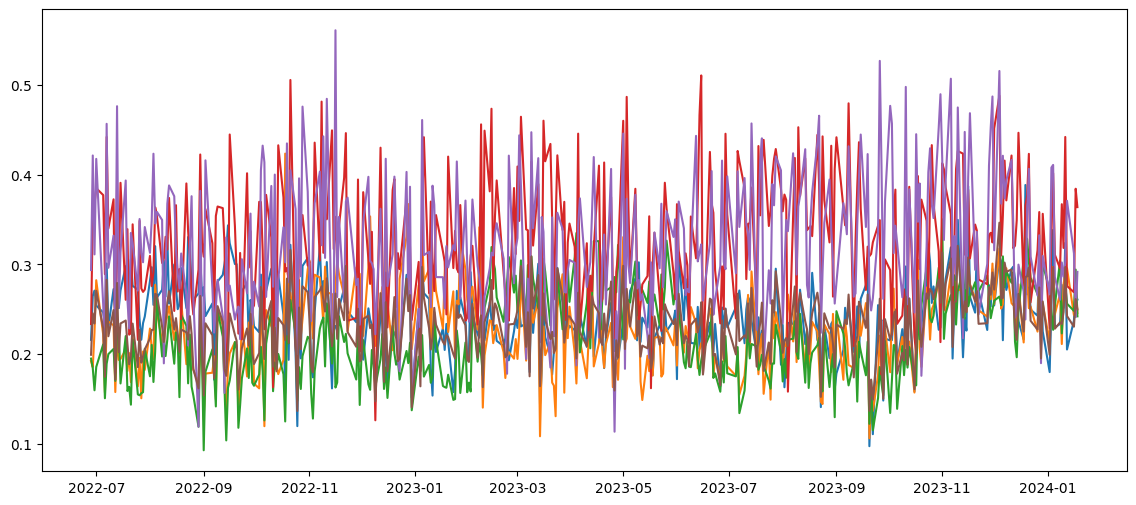

In [ ]:
folds_brie_train = brier_scores(last_h_train)

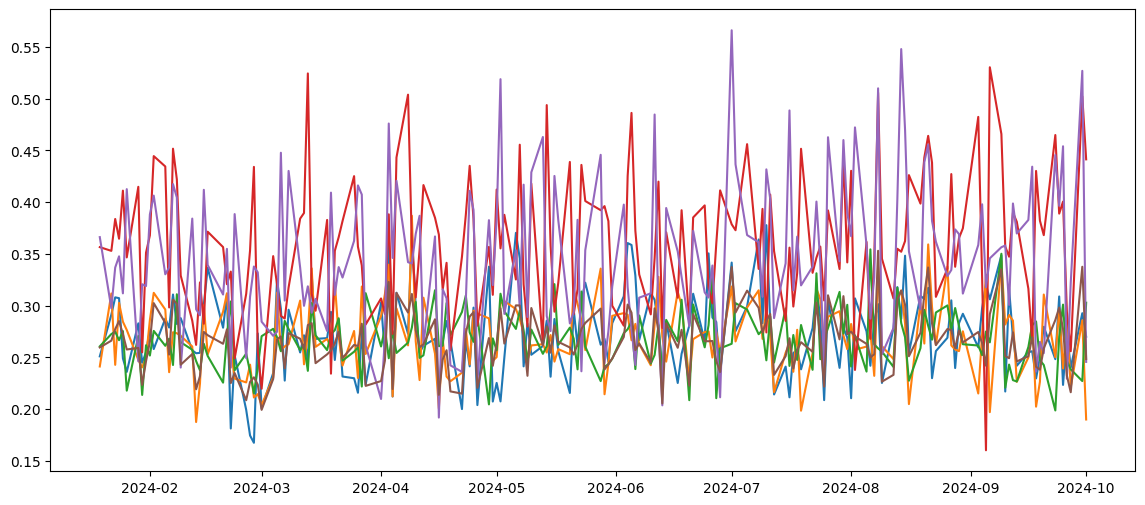

In [ ]:
folds_brie_test = brier_scores(last_h_test)

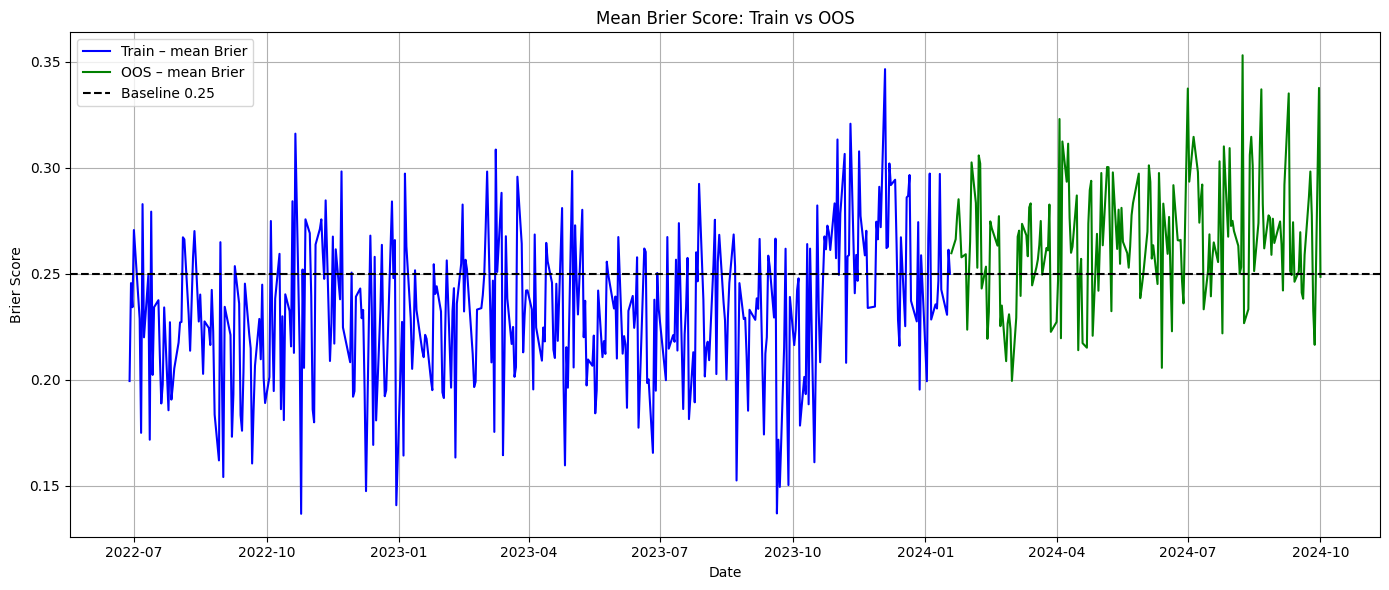

In [ ]:
plot_mean_brier_train_oos(train_brier=folds_brie_train,oos_brier= folds_brie_test,)


Brier=0.2659   ECE=0.0959   TEST F1=0.494   TEST MCC=0.004


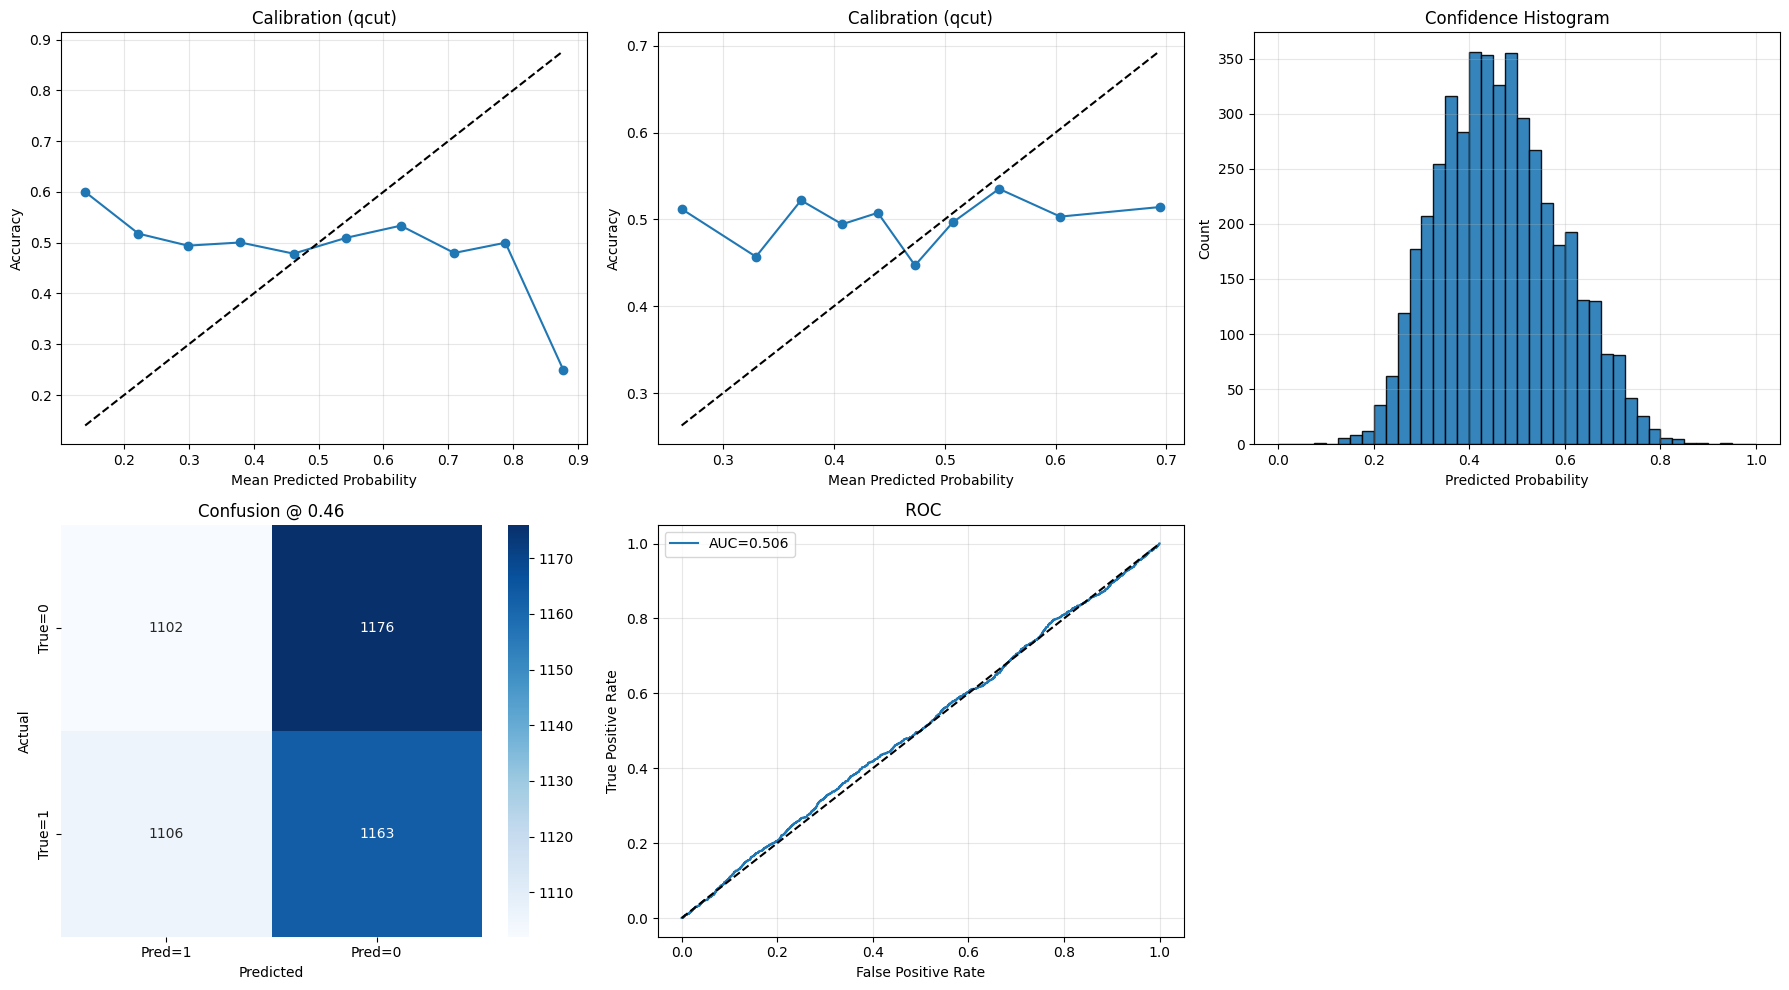

,precision,recall,f1-score,support,MCC
0.0,0.502779,0.516242,0.509422,2278.000000,
1.0,0.500906,0.487439,0.494081,2269.000000,
accuracy,0.501869,0.501869,0.501869,0.501869,0.004
macro avg,0.501842,0.501841,0.501751,4547.000000,
weighted avg,0.501844,0.501869,0.501766,4547.000000,


{'brier': np.float64(0.26592347490097595),
 'ece': np.float64(0.09592190794015894),
 'f1': 0.4940808577172214,
 'mcc': np.float64(0.0036832401409950784),
 'thr': np.float32(0.46212497)}

In [ ]:
plot_binary_metrics(
    p_test=last_h_test['mean_pred'],
    y_test=last_h_test['target'],
    threshold=last_h_train['mean_pred'].mean(),
    title = "",

)

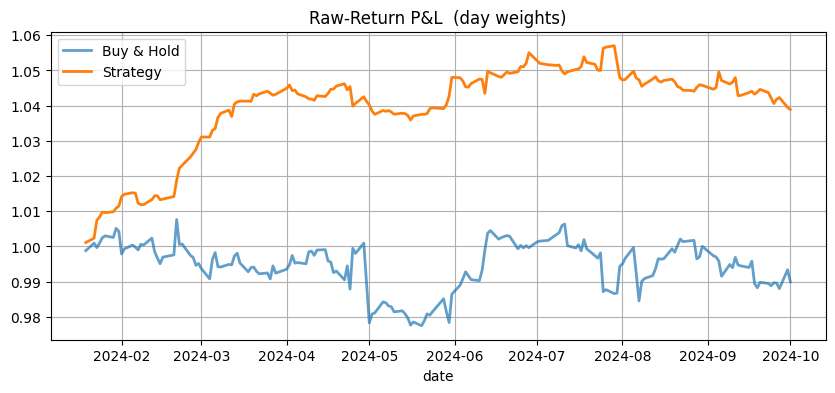

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown,t_stat,total_return
Strategy,0.056167,0.026224,2.141814,3.149116,-0.017142,1.681524,0.038903
Buy & Hold,-0.014397,0.050472,-0.285249,-0.359616,-0.029934,-0.293216,-0.010077


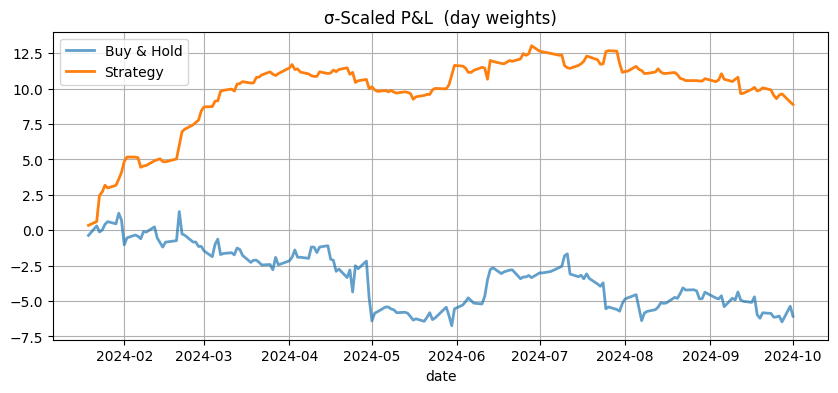

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown,t_stat,total_return
Strategy,12.717921,5.578380,2.279859,3.466483,-4.146975,1.624161,8.882357
Buy & Hold,-8.689426,9.311762,-0.933167,-1.130169,-8.058670,-1.083269,-6.068805


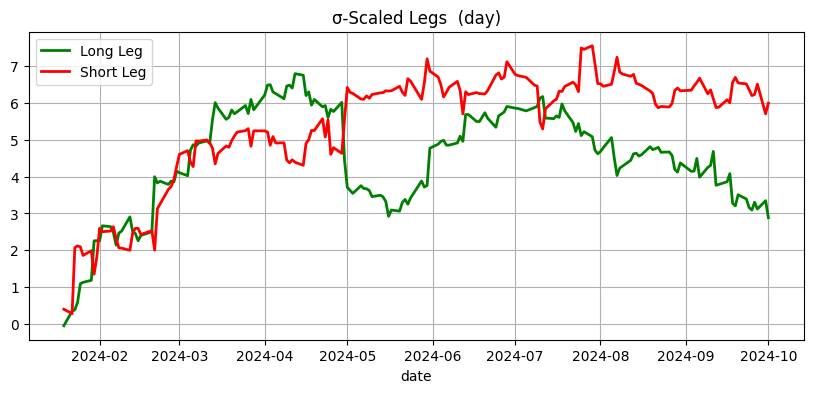

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown,t_stat,total_return
Long Leg,4.131001,5.105237,0.809169,1.072757,-3.913126,0.695842,2.885144
Short Leg,8.586920,5.513710,1.557376,2.574739,-1.904724,1.597473,5.997214


,Avg Return,Count,Precision,Weighted Precision
True Longs,0.000158,1106,NaN,NaN
False Shorts,-0.000146,1163,NaN,NaN
True Shorts,0.000158,1176,NaN,NaN
False Longs,-0.000138,1102,NaN,NaN
Actual Longs,0.003980,2269,NaN,NaN
Actual Shorts,-0.004063,2278,NaN,NaN
Predicted Longs,NaN,2208,0.500906,0.500223
Predicted Shorts,NaN,2339,0.502779,0.530962


In [ ]:
stats_s, stats_sigma, stats_legs, rt = full_strategy_report(
    last_h_test,
    compute_perf_stats,
    weight_mode="day"
)


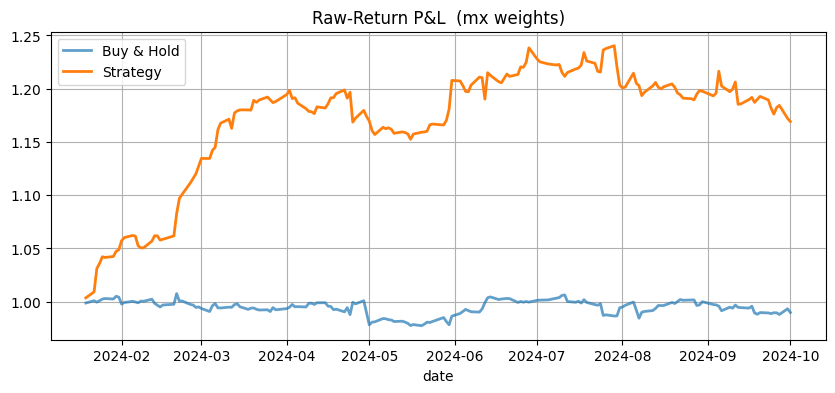

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown,t_stat,total_return
Strategy,0.250775,0.102892,2.437269,3.577466,-0.057412,1.760257,0.169153
Buy & Hold,-0.014397,0.050472,-0.285249,-0.359616,-0.029934,-0.293216,-0.010077


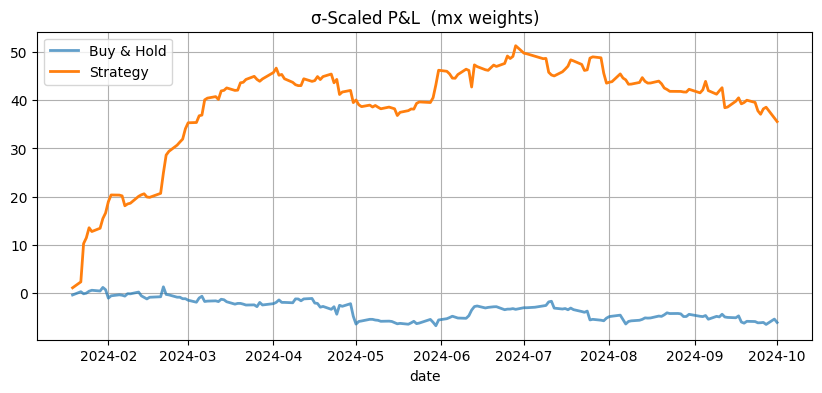

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown,t_stat,total_return
Strategy,50.934828,21.893297,2.326503,3.661471,-15.72069,1.636475,35.573531
Buy & Hold,-8.689426,9.311762,-0.933167,-1.130169,-8.05867,-1.083269,-6.068805


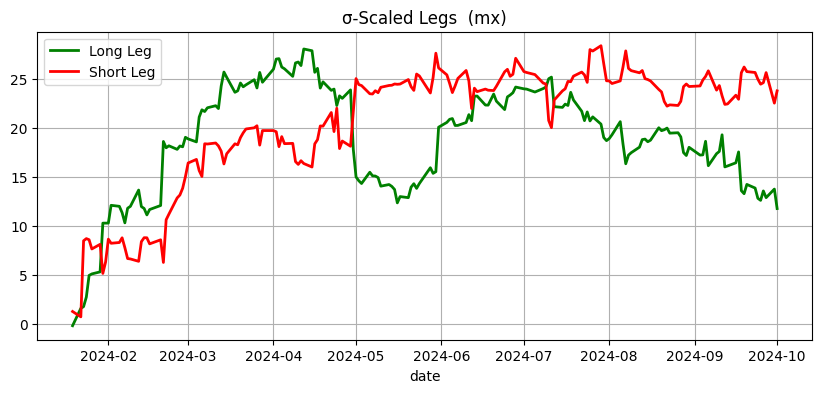

,ann_return,ann_vol,Sharpe,Sortino,Max_Drawdown,t_stat,total_return
Long Leg,16.875226,21.238671,0.794552,1.063745,-16.275619,0.684259,11.785872
Short Leg,34.059601,22.031312,1.545963,2.511435,-7.592051,1.621644,23.787658


,Avg Return,Count,Precision,Weighted Precision
True Longs,0.000643,1106,NaN,NaN
False Shorts,-0.000589,1163,NaN,NaN
True Shorts,0.000640,1176,NaN,NaN
False Longs,-0.000561,1102,NaN,NaN
Actual Longs,0.003980,2269,NaN,NaN
Actual Shorts,-0.004063,2278,NaN,NaN
Predicted Longs,NaN,2208,0.500906,0.500223
Predicted Shorts,NaN,2339,0.502779,0.530962


In [ ]:
stats_s, stats_sigma, stats_legs, rt = full_strategy_report(
    last_h_test,
    compute_perf_stats,
    weight_mode="mx"   # "equal", "day", or "mx"
)